<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

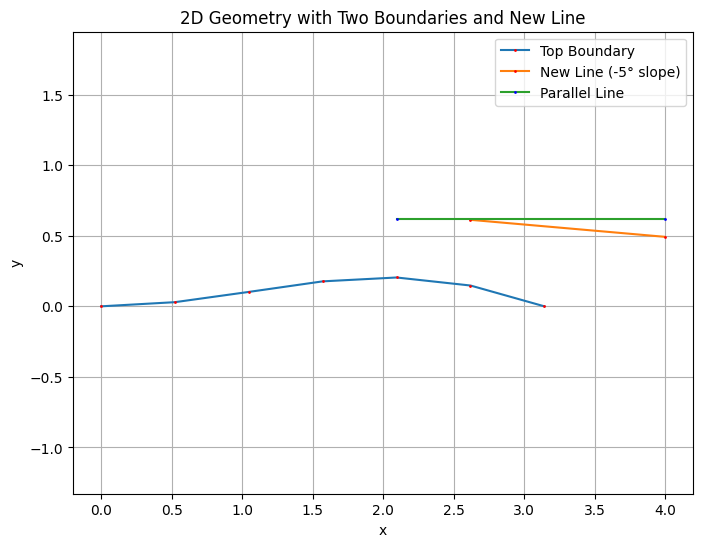

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define bump parameters
delta = np.pi / 28
K = 1.3
c = 0
yp = 0

# Define the function for the top boundary
def f_top(x):
    return np.sqrt(((x**2 * (np.tan(delta))**2) + c) / (1 / np.cos(np.arctan(yp / K)))**2) * np.sin(x) * np.sin((yp + np.pi) / 2)

# Discretize the function into points
N_points_bump = 7 # 200 N points for Bump
x_vals = np.linspace(0, np.pi, N_points_bump)
y_vals_top = f_top(x_vals)

# Define the starting point of the new line
Delta_x = 1 # 10 Distance in terms of grid points on the bump of the starting point of the inlet low part
Delta_conv = 1 # Distance in terms of grid points on the bump of the satrting point of the inlet upper part wrt lower part
y_dist = 3 # Multiplier of the maximum of the bump, the higher it is the higher the inlet is
thick_conv = 0.005 # thickness of convergent, the lower it is the more it becomes thin
index_line_bump = np.argmax(y_vals_top) + Delta_x
x_start, y_start = x_vals[index_line_bump], y_dist * max(y_vals_top)

x_start_up, y_start_up = x_vals[index_line_bump - Delta_conv], (y_dist * max(y_vals_top)) + thick_conv
angle_deg = -5
angle_rad = np.radians(angle_deg)

# Define the length of the line segment
End_line_param = x_vals[-1] + 4 - x_vals[-1]
line_length = End_line_param - x_start
x_end = x_start + line_length * np.cos(angle_rad)
y_end = y_start + line_length * np.sin(angle_rad)

x_end_up = x_end
y_end_up = y_start_up

# Define Far Field

Y_DIST = 250 # Multiplicator of how far away boundary is in terms of n* max of bump in y direction
Y_END = Y_DIST * y_vals_top[np.argmax(y_vals_top)] # Y end point of the boundary
X_DIST = -25 # Multiplier (negative since origin is on the bump) of how far away boundary is in terms of n* max of bump in x direct
X_START = X_DIST * x_vals[np.argmax(x_vals)]  # X Start point of the boundary
X_END = 25 * x_vals[np.argmax(x_vals)]  # X End point of the boundary

# .geo file creation:

with open("geometry.geo", "w") as file:
    # Write points for the bump
    for i, (x, y) in enumerate(zip(x_vals, y_vals_top)):
        file.write(f"Point({i + 1}) = {{{x}, {y}, 0, 1.0}};\n")
    for i in range(len(x_vals) - 1):
        file.write(f"Line({i + 1}) = {{{i + 1}, {i + 2}}};\n")

    # Define points for the new line with -5° slope and the upper parallel line
    new_point_start = len(x_vals) + 1
    new_point_end = new_point_start + 1
    upper_point_start = new_point_end + 1
    upper_point_end = upper_point_start + 1

    # Write the convex shape points and lines
    file.write(f"Point({new_point_start}) = {{{x_start}, {y_start}, 0, 1.0}};\n")
    file.write(f"Point({new_point_end}) = {{{x_end}, {y_end}, 0, 1.0}};\n")
    file.write(f"Line({len(x_vals) + 1}) = {{{new_point_start}, {new_point_end}}};\n")

    file.write(f"Point({upper_point_start}) = {{{x_start_up}, {y_start_up}, 0, 1.0}};\n")
    file.write(f"Point({upper_point_end}) = {{{x_end_up}, {y_end_up}, 0, 1.0}};\n")
    file.write(f"Line({len(x_vals) + 2}) = {{{upper_point_start}, {upper_point_end}}};\n")

    # Define connecting lines for closed convex surface
    file.write(f"Line({len(x_vals) + 3}) = {{{new_point_start}, {upper_point_start}}};\n")
    file.write(f"Line({len(x_vals) + 4}) = {{{new_point_end}, {upper_point_end}}};\n")

    # Boundary points for the entire domain
    boundary_point_1 = upper_point_end + 1
    boundary_point_2 = boundary_point_1 + 1
    boundary_point_3 = boundary_point_2 + 1
    boundary_point_4 = boundary_point_3 + 1
    boundary_point_5 = boundary_point_4 + 1

    file.write(f"Point({boundary_point_1}) = {{{x_end}, 0, 0, 1.0}};\n") # point 12
    file.write(f"Point({boundary_point_2}) = {{{X_END}, 0, 0, 1.0}};\n")
    file.write(f"Point({boundary_point_3}) = {{{X_END}, {Y_END}, 0, 1.0}};\n")
    file.write(f"Point({boundary_point_4}) = {{{X_START}, {Y_END}, 0, 1.0}};\n")
    file.write(f"Point({boundary_point_5}) = {{{X_START}, 0, 0, 1.0}};\n")

    # Define lines for the main boundary
    #file.write(f"Line({len(x_vals) + 5}) = {{{new_point_end}, {boundary_point_1}}};\n")  # Line from convex to lower boundary: line 12 to take out
    file.write(f"Line({len(x_vals) + 5}) = {{{new_point_start - 1}, {1}}};\n") # Connection line between end bump and begin bump
    file.write(f"Line({len(x_vals) + 6}) = {{{boundary_point_1}, {boundary_point_2}}};\n")
    file.write(f"Line({len(x_vals) + 7}) = {{{boundary_point_2}, {boundary_point_3}}};\n")
    file.write(f"Line({len(x_vals) + 8}) = {{{boundary_point_3}, {boundary_point_4}}};\n")
    file.write(f"Line({len(x_vals) + 9}) = {{{boundary_point_4}, {boundary_point_5}}};\n")
    file.write(f"Line({len(x_vals) + 10}) = {{{boundary_point_5}, 1}};\n")  # Connects back to start of bump
    file.write(f"Line({len(x_vals) + 11}) = {{{new_point_start - 1},{boundary_point_1} }};\n")  # Connects 7 -12


    # Define line loops and surfaces
    file.write("Line Loop(1) = {")
    file.write(", ".join(f"{i + 1}" for i in range(len(x_vals)-1)))
    file.write(f",{len(x_vals) + 5}") # add at last the closing line
    file.write("};\nPlane Surface(1) = {1};\n")

    # Define the closed surface that includes the convex shape
    file.write("Line Loop(2) = {")
    file.write(f"{len(x_vals) + 1}, {len(x_vals) + 4}, -{len(x_vals) + 2}, -{len(x_vals) + 3}")
    file.write("};\nPlane Surface(2) = {2};\n")

    # Boundary definition loop for the entire domain
    file.write("Line Loop(3) = {")
    file.write(", ".join(f"{i + 1}" for i in range(len(x_vals)-1)))
    file.write(f",{len(x_vals) + 11}, {len(x_vals) + 6}, {len(x_vals) + 7}, {len(x_vals) + 8}, {len(x_vals) + 9}, {len(x_vals) + 10}")
    file.write("};\nPlane Surface(3) = {3};\n")

    # Physical lines and surfaces for boundary conditions
    file.write(f"Physical Line('inlet') = {{{len(x_vals) + 9}}};\n")
    #file.write(f"Physical Line('lower wall') = {{{len(x_vals) + 10}, {len(x_vals) + 5}, {len(x_vals) + 6}}};\n")

    file.write("Physical Line('lower wall') = {")
    file.write(f"{len(x_vals) + 10},")
    file.write(", ".join(f"{i + 1}" for i in range(len(x_vals)-1)))
    file.write(f",{len(x_vals) + 11}, {len(x_vals) + 6}")
    file.write("};\n")

    file.write(f"Physical Line('upper wall') = {{{len(x_vals) + 8}}};\n")

    file.write("Physical Line('wall') = {")
    file.write(f"{len(x_vals) + 1}, {len(x_vals) + 4}, -{len(x_vals) + 2}, -{len(x_vals) + 3}")
    file.write("};\n")


    file.write(f"Physical Line('outlet') = {{{len(x_vals) + 7}}};\n")


    file.write("Physical Surface('VOLUME') = {1, 2, 3};\n")

    # MESH:




    from google.colab import files
    files.download("geometry.geo")



    # Plotting boundaries
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals_top, label="Top Boundary", marker="o", markersize=1, markeredgecolor="red")
plt.plot([x_start, x_end], [y_start, y_end], label="New Line (-5° slope)", marker="o", markersize=1, markeredgecolor="red")
plt.plot([x_start_up, x_end_up], [y_start_up, y_end_up], label="Parallel Line", marker="o", markersize=1, markeredgecolor="blue")

# Add labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Geometry with Two Boundaries and New Line")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define bump parameters
delta = np.pi / 28
K = 1.3
c = 0
yp = 0

# Define the function for the top boundary
def f_top(x):
    return np.sqrt(((x**2 * (np.tan(delta))**2) + c) / (1 / np.cos(np.arctan(yp / K)))**2) * np.sin(x) * np.sin((yp + np.pi) / 2)

# Discretize the function into points
N_points_bump = 200 # Number of points for bump
x_vals = np.linspace(0, np.pi, N_points_bump)
y_vals_top = f_top(x_vals)

# Define the starting point of the new line

Delta_x = 1 # Distance in terms of discretization points from the maximum of the bump
Delta_conv = 1 # Distance in terms of discretization points from the start of the inner part of conv. to outer
y_dist = 3 # multiplication factor that increases distance between max of bump and initial point of inner convergent
thick_conv = 0.005 # Additive quantity to the end point of the convergent to close it
angle_deg = -5 # Angle of the convergent, taken from Web Plot Digitizer from image of the thesis of sweden guy
index_line_bump = np.argmax(y_vals_top) + Delta_x
x_start, y_start = x_vals[index_line_bump], y_dist * max(y_vals_top)

x_start_up, y_start_up = x_vals[index_line_bump - Delta_conv], (y_dist * max(y_vals_top)) + thick_conv
angle_rad = np.radians(angle_deg)

# Define the length of the line segment
End_line_param = x_vals[-1] + 4 - x_vals[-1]
line_length = End_line_param - x_start
x_end = x_start + line_length * np.cos(angle_rad)
y_end = y_start + line_length * np.sin(angle_rad)

x_end_up = x_end
y_end_up = y_start_up

# Define Far Field
Y_DIST = 250 # Multiplication factor of maximum of bump to create far field Y
Y_END = Y_DIST * y_vals_top[np.argmax(y_vals_top)]
X_DIST = -25 # Multiplication factor of end x point of bump to create far field X
X_START = X_DIST * x_vals[np.argmax(x_vals)]
X_END = 25 * x_vals[np.argmax(x_vals)]

# .geo file creation:
with open("geometry.geo", "w") as file:

    file.write("h = 0.01;\n") # Size of cells close to bump and convergent
    file.write("H = 1.5;\n") # Size of cells close to farfield
    file.write("r = 1.0;\n") # Size of geometrical step of structured mesh

    # Write points for the bump
    for i, (x, y) in enumerate(zip(x_vals, y_vals_top)):
        file.write(f"Point({i + 1}) = {{{x}, {y}, 0, h}};\n")
    for i in range(len(x_vals) - 1):
        file.write(f"Line({i + 1}) = {{{i + 1}, {i + 2}}};\n")

    # Define points for the new line with -5° slope and the upper parallel line
    new_point_start = len(x_vals) + 1
    new_point_end = new_point_start + 1
    upper_point_start = new_point_end + 1
    upper_point_end = upper_point_start + 1

    # Write the convex shape points and lines
    file.write(f"Point({new_point_start}) = {{{x_start}, {y_start}, 0, h}};\n")
    file.write(f"Point({new_point_end}) = {{{x_end}, {y_end}, 0, h}};\n")
    file.write(f"Line({len(x_vals) + 1}) = {{{new_point_start}, {new_point_end}}};\n")

    file.write(f"Point({upper_point_start}) = {{{x_start_up}, {y_start_up}, 0, h}};\n")
    file.write(f"Point({upper_point_end}) = {{{x_end_up}, {y_end_up}, 0, h}};\n")
    file.write(f"Line({len(x_vals) + 2}) = {{{upper_point_start}, {upper_point_end}}};\n")

    # Define connecting lines for closed convex surface
    file.write(f"Line({len(x_vals) + 3}) = {{{new_point_start}, {upper_point_start}}};\n")
    file.write(f"Line({len(x_vals) + 4}) = {{{new_point_end}, {upper_point_end}}};\n")

    # Boundary points for the entire domain
    boundary_point_1 = upper_point_end + 1
    boundary_point_2 = boundary_point_1 + 1
    boundary_point_3 = boundary_point_2 + 1
    boundary_point_4 = boundary_point_3 + 1
    boundary_point_5 = boundary_point_4 + 1

    file.write(f"Point({boundary_point_1}) = {{{x_end}, 0, 0, H}};\n")
    file.write(f"Point({boundary_point_2}) = {{{X_END}, 0, 0, H}};\n")
    file.write(f"Point({boundary_point_3}) = {{{X_END}, {Y_END}, 0, H}};\n")
    file.write(f"Point({boundary_point_4}) = {{{X_START}, {Y_END}, 0, H}};\n")
    file.write(f"Point({boundary_point_5}) = {{{X_START}, 0, 0, H}};\n")

    # Define lines for the main boundary
    file.write(f"Line({len(x_vals) + 6}) = {{{boundary_point_1}, {boundary_point_2}}};\n")
    file.write(f"Line({len(x_vals) + 7}) = {{{boundary_point_2}, {boundary_point_3}}};\n")
    file.write(f"Line({len(x_vals) + 8}) = {{{boundary_point_3}, {boundary_point_4}")
    file.write("};\n")
    file.write(f"Line({len(x_vals) + 9}) = {{{boundary_point_4}, {boundary_point_5}}};\n")
    file.write(f"Line({len(x_vals) + 10}) = {{{boundary_point_5}, 1}};\n")  # Connect back to start of bump
    file.write(f"Line({len(x_vals) + 11}) = {{{new_point_start - 1},{boundary_point_1} }};\n")

    # Define a single Line Loop for the entire domain boundary (the outermost loop)
    file.write("Line Loop(1) = {")
    file.write(", ".join(f"{i + 1}" for i in range(len(x_vals)-1)))  # Lines on the bump boundary
    file.write(f",{len(x_vals) + 11}, {len(x_vals) + 6}, {len(x_vals) + 7}, {len(x_vals) + 8}, {len(x_vals) + 9}, {len(x_vals) + 10}")
    file.write("};\n")

    file.write("Line Loop(2) = {")
    file.write(f"{len(x_vals) + 1}, {len(x_vals) + 4}, -{len(x_vals) + 2}, -{len(x_vals) + 3}")
    file.write("};\n")

    file.write("Plane Surface(1) = {1, 2};\n") # It tells GMSH to mesh only on 1 and not account for 2

    # Physical Surface definition
    file.write("Physical Surface('VOLUME') = {1};\n")

    # Physical lines and surfaces for boundary conditions
    file.write(f"Physical Line('inlet') = {{{len(x_vals) + 9}}};\n")

    file.write("Physical Line('lower wall') = {")
    file.write(f"{len(x_vals) + 10},")
    file.write(", ".join(f"{i + 1}" for i in range(len(x_vals)-1)))
    file.write(f",{len(x_vals) + 11}, {len(x_vals) + 6}")
    file.write("};\n")

    file.write(f"Physical Line('upper wall') = {{{len(x_vals) + 8}}};\n")

    file.write("Physical Line('CONVERGENT') = {")
    file.write(f"{len(x_vals) + 1}, {len(x_vals) + 4}, -{len(x_vals) + 2}, -{len(x_vals) + 3}")
    file.write("};\n")

    file.write(f"Physical Line('outlet') = {{{len(x_vals) + 7}}};\n")


    # MESH:

# 1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay,
# 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms

    file.write("Mesh.Algorithm = 6; // Frontal-Delaunay for quads\n")
    file.write("Mesh.RecombineAll = 1; // Enable recombination for quad elements\n")

    # Boundary Layer Field

    file.write("HWALL = 0.005;\n") # Initial cell size at the wall
    file.write("THICKNESS = 0.02;\n") # Total thickness of the boundary layer
    file.write("GROWTH_RATE = 1.2;\n") # Growth rate of cells within the boundary layer

    #file.write("Field[1] = BoundaryLayer;\n")
    #file.write(f"Field[1].hwall_n = HWALL;\n")
    #file.write(f"Field[1].thickness = THICKNESS; \n")
    #file.write(f"Field[1].ratio = GROWTH_RATE;\n")
    #file.write(f"Field[1].EdgesList = {{{len(x_vals) + 1}, {len(x_vals) + 2}, {len(x_vals) + 3}, {len(x_vals) + 4}}};\n")

    # Boundary Layer Field (Modified)
    #file.write("Field[1] = BoundaryLayer_Conv;\n")
    #file.write("Field[1].Quads = 1;\n")
    #file.write("Field[1].Ratio = 1.1;\n")
    #file.write("Field[1].Size = 0.00001;\n")
    #file.write("Field[1].Thickness = 0.07;\n")
    #file.write("Field[1].FanPointsList = {1};\n")
    #file.write("Field[1].FanPointsSizesList = {40};\n")
    #file.write(f"Field[1].EdgesList = {{{len(x_vals) + 1}, {len(x_vals) + 2}, {len(x_vals) + 3}, {len(x_vals) + 4}}};\n")
    #file.write("BoundaryLayer Field = 1;\n")

    file.write("Field[1] = BoundaryLayer;\n")
    file.write("Field[1].Quads = 1;\n")
    file.write("Field[1].Ratio = 1.1;\n")
    file.write("Field[1].Size = 0.00001;\n")
    file.write("Field[1].Thickness = 0.07;\n")
    file.write("Field[1].FanPointsList = {1};\n")
    file.write("Field[1].FanPointsSizesList = {40};\n")
    file.write(f"Field[1].PointsList = {{{new_point_end}}};\n")
    file.write("BoundaryLayer Field = 1;\n")


    # Structured mesh on the bump
    #file.write(f"Transfinite Curve {{")
    #file.write(", ".join(f"{i + 1}" for i in range(len(x_vals) - 1)))  # Lines forming the bump
    #file.write(f"}} = {N_points_bump} Using Progression r;\n")  # Number of points and progression type



# Download the file (if running in an environment that supports file download)
from google.colab import files
files.download("geometry.geo")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from os import write
import numpy as np
import matplotlib.pyplot as plt

# Define bump parameters
delta = np.pi / 28
K = 1.3
c = 0
yp = 0

# Define the function for the top boundary
def f_top(x):
    return np.sqrt(((x**2 * (np.tan(delta))**2) + c) / (1 / np.cos(np.arctan(yp / K)))**2) * np.sin(x) * np.sin((yp + np.pi) / 2)

# Discretize the function into points
N_points_bump = 7 # Number of points for bump
x_vals = np.linspace(0, np.pi, N_points_bump)
y_vals_top = f_top(x_vals)

# Define the starting point of the new line

Delta_x = 1 # Distance in terms of discretization points from the maximum of the bump
Delta_conv = 1 # Distance in terms of discretization points from the start of the inner part of conv. to outer
y_dist = 3 # multiplication factor that increases distance between max of bump and initial point of inner convergent
thick_conv = 0.005 # Additive quantity to the end point of the convergent to close it
angle_deg = -5 # Angle of the convergent, taken from Web Plot Digitizer from image of the thesis of sweden guy
index_line_bump = np.argmax(y_vals_top) + Delta_x
x_start, y_start = x_vals[index_line_bump], y_dist * max(y_vals_top)

x_start_up, y_start_up = x_vals[index_line_bump - Delta_conv], (y_dist * max(y_vals_top)) + thick_conv
angle_rad = np.radians(angle_deg)

# Define the length of the line segment
End_line_param = x_vals[-1] + 4 - x_vals[-1]
line_length = End_line_param - x_start
x_end = x_start + line_length * np.cos(angle_rad)
y_end = y_start + line_length * np.sin(angle_rad)

x_end_up = x_end
y_end_up = y_start_up

# Define Far Field
Y_DIST = 250 # Multiplication factor of maximum of bump to create far field Y
Y_END = Y_DIST * y_vals_top[np.argmax(y_vals_top)]
X_DIST = -25 # Multiplication factor of end x point of bump to create far field X
X_START = X_DIST * x_vals[np.argmax(x_vals)]
X_END = 25 * x_vals[np.argmax(x_vals)]

# .geo file creation:
with open("geometry.geo", "w") as file:

    file.write("h = 0.01;\n") # Size of cells close to bump and convergent
    file.write("H = 1.5;\n") # Size of cells close to farfield
    file.write("r = 1.0;\n") # Size of geometrical step of structured mesh

    # Write points for the bump
    for i, (x, y) in enumerate(zip(x_vals, y_vals_top)):
      file.write(f"Point({i + 1}) = {{{x}, {y}, 0, h}};\n")

# Define spline from the first point to the maximum
    file.write(f"Spline(1) = {{{', '.join(str(i + 1) for i in range(np.argmax(y_vals_top) + 1))}}};\n")

# Define spline from the maximum to the end
    file.write(f"Spline(2) = {{{', '.join(str(i + 1) for i in range(np.argmax(y_vals_top), len(x_vals)))}")
    file.write("};\n")

    # Define points for the new line with -5° slope and the upper parallel line
    new_point_start = len(x_vals) + 1
    new_point_end = new_point_start + 1
    upper_point_start = new_point_end + 1
    upper_point_end = upper_point_start + 1

    # Write the convex shape points and lines
    file.write(f"Point({new_point_start}) = {{{x_start}, {y_start}, 0, h}};\n")
    file.write(f"Point({new_point_end}) = {{{x_end}, {y_end}, 0, h}};\n")
    file.write(f"Line({len(x_vals) + 1}) = {{{new_point_start}, {new_point_end}}};\n")

    file.write(f"Point({upper_point_start}) = {{{x_start_up}, {y_start_up}, 0, h}};\n")
    file.write(f"Point({upper_point_end}) = {{{x_end_up}, {y_end_up}, 0, h}};\n")
    file.write(f"Line({len(x_vals) + 2}) = {{{upper_point_start}, {upper_point_end}}};\n")

    # Define connecting lines for closed convex surface
    file.write(f"Line({len(x_vals) + 3}) = {{{new_point_start}, {upper_point_start}}};\n")
    file.write(f"Line({len(x_vals) + 4}) = {{{new_point_end}, {upper_point_end}}};\n")

    # Boundary points for the entire domain
    boundary_point_1 = upper_point_end + 1
    boundary_point_2 = boundary_point_1 + 1
    boundary_point_3 = boundary_point_2 + 1
    boundary_point_4 = boundary_point_3 + 1
    boundary_point_5 = boundary_point_4 + 1

    file.write(f"Point({boundary_point_1}) = {{{x_end}, 0, 0, H}};\n")
    file.write(f"Point({boundary_point_2}) = {{{X_END}, 0, 0, H}};\n")
    file.write(f"Point({boundary_point_3}) = {{{X_END}, {Y_END}, 0, H}};\n")
    file.write(f"Point({boundary_point_4}) = {{{X_START}, {Y_END}, 0, H}};\n")
    file.write(f"Point({boundary_point_5}) = {{{X_START}, 0, 0, H}};\n")

    # Define lines for the main boundary
    file.write(f"Line({len(x_vals) + 6}) = {{{boundary_point_1}, {boundary_point_2}}};\n")
    file.write(f"Line({len(x_vals) + 7}) = {{{boundary_point_2}, {boundary_point_3}}};\n")
    file.write(f"Line({len(x_vals) + 8}) = {{{boundary_point_3}, {boundary_point_4}")
    file.write("};\n")
    file.write(f"Line({len(x_vals) + 9}) = {{{boundary_point_4}, {boundary_point_5}}};\n")
    file.write(f"Line({len(x_vals) + 10}) = {{{boundary_point_5}, 1}};\n")  # Connect back to start of bump
    file.write(f"Line({len(x_vals) + 11}) = {{{new_point_start - 1},{boundary_point_1} }};\n")

    # Define a single Line Loop for the entire domain boundary (the outermost loop)
    file.write("Line Loop(1) = {")
    file.write("1, 2") # Spline 1 and 2
    file.write(f",{len(x_vals) + 11}, {len(x_vals) + 6}, {len(x_vals) + 7}, {len(x_vals) + 8}, {len(x_vals) + 9}, {len(x_vals) + 10}")
    file.write("};\n")

    file.write("Line Loop(2) = {")
    file.write(f"{len(x_vals) + 1}, {len(x_vals) + 4}, -{len(x_vals) + 2}, -{len(x_vals) + 3}")
    file.write("};\n")

    file.write("Plane Surface(1) = {1, 2};\n") # It tells GMSH to mesh only on 1 and not account for 2

    # Physical Surface definition
    file.write("Physical Surface('VOLUME') = {1};\n")

    # Physical lines and surfaces for boundary conditions
    file.write(f"Physical Line('inlet') = {{{len(x_vals) + 9}}};\n")

    file.write("Physical Line('lower wall') = {")
    file.write(f"{len(x_vals) + 10},")
    file.write("1, 2") # Spline 1 and 2
    file.write(f",{len(x_vals) + 11}, {len(x_vals) + 6}")
    file.write("};\n")

    file.write(f"Physical Line('upper wall') = {{{len(x_vals) + 8}}};\n")

    file.write("Physical Line('CONVERGENT') = {")
    file.write(f"{len(x_vals) + 1}, {len(x_vals) + 4}, -{len(x_vals) + 2}, -{len(x_vals) + 3}")
    file.write("};\n")

    file.write(f"Physical Line('outlet') = {{{len(x_vals) + 7}}};\n")


    # MESH:

# 1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay,
# 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms

    file.write("Mesh.Algorithm = 2; // Frontal-Delaunay for quads\n")
    file.write("Mesh.RecombineAll = 1; // Enable recombination for quad elements\n")

    # Boundary Layer Field

    file.write("HWALL = 0.005;\n") # Initial cell size at the wall
    file.write("THICKNESS = 0.02;\n") # Total thickness of the boundary layer
    file.write("GROWTH_RATE = 1.2;\n") # Growth rate of cells within the boundary layer

    #file.write("Field[1] = BoundaryLayer;\n")
    #file.write(f"Field[1].hwall_n = HWALL;\n")
    #file.write(f"Field[1].thickness = THICKNESS; \n")
    #file.write(f"Field[1].ratio = GROWTH_RATE;\n")
    #file.write(f"Field[1].EdgesList = {{{len(x_vals) + 1}, {len(x_vals) + 2}, {len(x_vals) + 3}, {len(x_vals) + 4}}};\n")

    # Boundary Layer Field (Modified)
    #file.write("Field[1] = BoundaryLayer_Conv;\n")
    #file.write("Field[1].Quads = 1;\n")
    #file.write("Field[1].Ratio = 1.1;\n")
    #file.write("Field[1].Size = 0.00001;\n")
    #file.write("Field[1].Thickness = 0.07;\n")
    #file.write("Field[1].FanPointsList = {1};\n")
    #file.write("Field[1].FanPointsSizesList = {40};\n")
    #file.write(f"Field[1].EdgesList = {{{len(x_vals) + 1}, {len(x_vals) + 2}, {len(x_vals) + 3}, {len(x_vals) + 4}}};\n")
    #file.write("BoundaryLayer Field = 1;\n")

    file.write("Field[1] = BoundaryLayer;\n")
    file.write("Field[1].CurvesList = {")
    file.write(f"1, 2, {len(x_vals) + 11}")  # Include necessary line or curve numbers
    file.write("};\n")
    file.write("Field[1].Quads = 1;\n")
    file.write("Field[1].Ratio = 1.1;\n")
    file.write("Field[1].Size = 0.00001;\n")
    file.write("Field[1].Thickness = 0.07;\n")
    #file.write("Field[1].FanPointsList = {1};\n")
    #file.write("Field[1].FanPointsSizesList = {3};\n")
    file.write(f"Field[1].PointsList = {{{len(x_vals)}}};\n")
    file.write("BoundaryLayer Field = 1;\n")


    # Structured mesh on the bump
    #file.write(f"Transfinite Curve {{")
    #file.write(", ".join(f"{i + 1}" for i in range(len(x_vals) - 1)))  # Lines forming the bump
    #file.write(f"}} = {N_points_bump} Using Progression r;\n")  # Number of points and progression type



# Download the file (if running in an environment that supports file download)
from google.colab import files
files.download("geometry.geo")

print(boundary_point_5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

16
